# Simulating the game dynamics

In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.special import beta as beta_func
from scipy.misc import comb
def beta_binomial(n, alpha, beta):
    return np.matrix([comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta) for k in range(n)])
def beta_binomial_expectation(prior):
    return sum([prior[i]*i/len(prior) for i in range(len(prior))])

In [2]:
import numpy as np

In [3]:
import time

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def discrete_time_replicator_dynamics(n_steps, X, Y, A, B, P):
    """Calculate the discrete-time replicator dynamics for"""
    # Get the number of states, signals, and actions
    X_nrow = X.shape[0]
    X_ncol = X.shape[1]
    Y_nrow = Y.shape[0] # Same as X_ncol
    Y_ncol = Y.shape[1] # Often, but not necessarily, the same as X_nrow
    # Create empty arrays to hold the population states over time
    X_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    Y_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    # Set the initial state
    X_t[0,:] = X.ravel()
    Y_t[0,:] = Y.ravel()
    # Iterate forward over (n-1) steps
    for i in range(1,n_steps):
        # Get the previous state
        X_prev = X_t[i-1,:].reshape(X_nrow, X_ncol)
        Y_prev = Y_t[i-1,:].reshape(Y_nrow, Y_ncol)
        # Calculate the scaling factors
        E_X = A * Y_prev.T
        X_bar = (((A * Y_prev.T) * X_prev.T).diagonal()).T
        X_hat = E_X / X_bar
        # 
        C = np.divide(np.multiply(P.T, X_prev), (P * X_prev)[0])
        E_Y = (B.T * C).T
        Y_bar = ((E_Y*Y_prev.T).diagonal()).T
        Y_hat = np.divide(E_Y, Y_bar)
        # Calculate next states
        X_t[i,:] = np.multiply(X_prev, X_hat).ravel()
        Y_t[i,:] = np.multiply(Y_prev, Y_hat).ravel()
    return X_t, Y_t

In [6]:
def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
    #return 1 - abs(action - state - (1-state)*b)
def U_R(state, action):
    return 1 - (action - state)**2
# Define functions to map integers to interval [0,1]
def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

In [7]:
number=200
prior = beta_binomial(number, 1, 2)

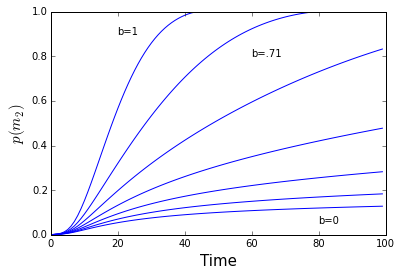

In [8]:
#hfont = {'fontname':'Helvetica'}
for k in np.linspace(0, 1, num=7): # 10, 2, 2, .2
    #print k
    # Define number of states
    number = 200
    # Define prior probability
    prior = beta_binomial(number, 1, 2)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    b = k
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, 10, 1)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, 1, 2), beta_binomial(number, 28, 2)))
    # Solve and plot
    X_sol, Y_sol = discrete_time_replicator_dynamics(100, X0, Y0, A, B, P)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    plt.plot(m2_sol, 'b')
plt.ylim(0,1)
plt.xlabel('Time', fontsize=15)
plt.ylabel(r'$p(m_2)$', fontsize=15)
plt.text(20, .9, r'b=1')
plt.text(60, .8, r'b=.71')
plt.text(80, .05, r'b=0')
#plt.savefig("replicator-multiple-b.pdf", format='pdf', dpi=1000)
plt.show()

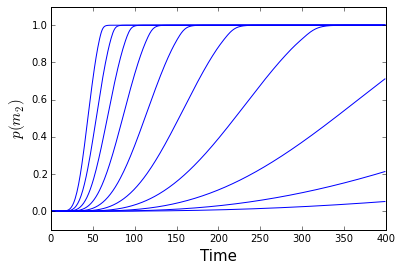

In [8]:
for k in np.linspace(.25, .75, num=10): # 10, 2, 2, .2
    #print k
    # Define number of states
    number = 200
    # Define prior probability
    prior = beta_binomial(number, 1, 20)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    b = k
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, 7, 1)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, 1, 2), beta_binomial(number, 28, 2)))
    # Solve and plot
    X_sol, Y_sol = discrete_time_replicator_dynamics(400, X0, Y0, A, B, P)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    plt.plot(m2_sol, 'b')
plt.ylim(-.1,1.1)
plt.xlabel('Time', fontsize=15)
plt.ylabel(r'$p(m_2)$', fontsize=15)
plt.savefig("replicator-free-prior.pdf", format='pdf', dpi=1000)
plt.show()

# Fitting the signaling model to historical corpus data

In [11]:
import pandas as pd
import numpy as np
df1 = pd.read_csv("./first_curve_data.csv")

In [9]:
def loss_first(params):
    # Unpack the paramters
    a_x = params[0] # Sender initial state parameter
    b_y1 = params[1] # Receiver response to m1 parameter
    b_y2 = params[2] # Receiver response to m2 parameter
    b = params[3] # 
    k=1 # Change this to alter scaling parameter
    # Construct initial states
    # Number of states and actions
    number = 200
    # Define prior probability
    prior = beta_binomial(number, 1, 2)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, a_x, 1)#b_x)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Calculate expected state given m2
    p_ti_m2 = np.multiply(X0[:,1], prior.T)
    p_m2 = prior * X0[:,1]
    p_t_m2 = p_ti_m2 / p_m2
    E_t_m2 = (np.array(range(200)) * p_t_m2) / number
    scale = E_t_m2[0,0]/(1 - E_t_m2[0,0])
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, .5*b_y1, b_y1), beta_binomial(number, scale*b_y2, b_y2)))
    # Iterate through the discrete-time replicator dynamics
    X_sol, Y_sol = discrete_time_replicator_dynamics(376, X0, Y0, A, B, P)
    # Get p(m_2) over time
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    # Get data indices
    indices = np.subtract(df1.year.unique(), min(df1.year))
    # Get count of tokens for indices
    counts = df1.groupby('year').size() #.loc[index + 1125]
    # Get count of value==1 for indices
    values = df1.groupby('year').aggregate(np.sum)
    # Initialize RSS value
    RSS = 0
    # Loop over indices
    for index in indices:
        zero_count = counts.loc[index + min(df1.year)] - values.loc[index + min(df1.year), 'value']
        one_count = values.loc[index + min(df1.year), 'value']
        #
        RSS += zero_count*(0 - m2_sol[index])**2 + one_count*(1 - m2_sol[index])**2
    return RSS

In [12]:
def loss_first(params):
    # Unpack the paramters
    a_x = params[0] # Sender initial state parameter
    b_y1 = params[1] # Receiver response to m1 parameter
    b_y2 = params[2] # Receiver response to m2 parameter
    b_p = params[3]
    b = params[4] # This 
    k=1 # Change this to alter scaling parameter
    # Construct initial states
    # Number of states and actions
    number = 200
    # Define prior probability
    prior = beta_binomial(number, 1, b_p)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, a_x, 1)#b_x)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Calculate expected state given m2
    p_ti_m2 = np.multiply(X0[:,1], prior.T)
    p_m2 = prior * X0[:,1]
    p_t_m2 = p_ti_m2 / p_m2
    E_t_m2 = (np.array(range(200)) * p_t_m2) / number
    scale = E_t_m2[0,0]/(1 - E_t_m2[0,0])
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, .5*b_y1, b_y1), beta_binomial(number, scale*b_y2, b_y2)))
    # Iterate through the discrete-time replicator dynamics
    X_sol, Y_sol = discrete_time_replicator_dynamics(376, X0, Y0, A, B, P)
    # Get p(m_2) over time
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    # Get data indices
    indices = np.subtract(df1.year.unique(), min(df1.year))
    # Get count of tokens for indices
    counts = df1.groupby('year').size() #.loc[index + 1125]
    # Get count of value==1 for indices
    values = df1.groupby('year').aggregate(np.sum)
    # Initialize RSS value
    RSS = 0
    # Loop over indices
    for index in indices:
        zero_count = counts.loc[index + min(df1.year)] - values.loc[index + min(df1.year), 'value']
        one_count = values.loc[index + min(df1.year), 'value']
        #
        RSS += zero_count*(0 - m2_sol[index])**2 + one_count*(1 - m2_sol[index])**2
    return RSS

In [13]:
# Start with initial guesses and bounds
guess = np.array([10, 2, 2, 10, .2])
bnds = ((1, 100), (1, 100), (1, 100), (1, 100), (0,1))
# Start timer
start = time.time()
# Solve for various numbers of iterations
res = minimize(loss_first, x0=guess, method="COBYLA", bounds=bnds, options={"maxiter" : 2000, "disp" : True})
end = time.time()
elapsed = end - start
m, s = divmod(elapsed, 60)
print res.message + " " + "%02d:%02d" % (m, s)
print res

Optimization terminated successfully. 00:27
  status: 1
    nfev: 95
   maxcv: 0.0
 success: True
     fun: 474.19709649299085
       x: array([ 9.93147612,  1.63908383,  3.22659236,  9.8951206 ,  0.45951074])
 message: 'Optimization terminated successfully.'


Use the following if you don't want to run the following optimization.

In [ ]:
# short_res = res.x # Use this to define the shortcut
short_res = [ 9.57057411,  2.11689308,  2.96493063,  0.49132877]

In [ ]:
b = short_res[4]

A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
# Define sender population
X0_m2 = beta_binomial(number,  short_res[0], 1)
X0_m1 = 1 - X0_m2
X0 = np.vstack((X0_m1, X0_m2)).T

p_ti_m2 = np.multiply(X0[:,1], prior.T)
p_m2 = prior * X0[:,1]
p_t_m2 = p_ti_m2 / p_m2
E_t_m2 = (np.array(range(200)) * p_t_m2) / number
scale = E_t_m2[0,0]/(1 - E_t_m2[0,0])

# Define receiver population
Y0 = np.vstack((beta_binomial(number, .5*short_res[1], short_res[1]),\
              beta_binomial(number, scale*short_res[2], short_res[2])))
# Solve and plot
X_sol, Y_sol = discrete_time_replicator_dynamics(376, X0, Y0, A, B, P)
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
years = [1125 + item for item in range(376)]
plt.plot(years, m2_sol, 'b')
plt.ylim(0,1)
plt.xlim(1075, 1525)
plt.xlabel('Year', fontsize=15, **hfont)
plt.ylabel(r'$p(m_2)$', fontsize=15)
plt.text(1150, .7, r'$\hat{b}=0.49132877$')
plt.savefig("m2_sol.eps", format='eps', dpi=1000)
plt.show()

In [14]:
res

  status: 1
    nfev: 95
   maxcv: 0.0
 success: True
     fun: 474.19709649299085
       x: array([ 9.93147612,  1.63908383,  3.22659236,  9.8951206 ,  0.45951074])
 message: 'Optimization terminated successfully.'

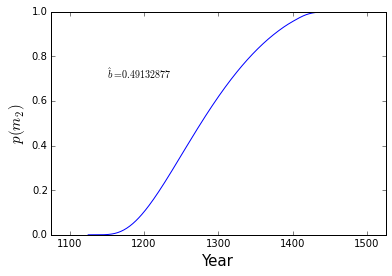

In [19]:
b = res.x[4]
prior = beta_binomial(number, 1, res.x[3])
A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
# Define sender population
X0_m2 = beta_binomial(number,  res.x[0], 1)
X0_m1 = 1 - X0_m2
X0 = np.vstack((X0_m1, X0_m2)).T

p_ti_m2 = np.multiply(X0[:,1], prior.T)
p_m2 = prior * X0[:,1]
p_t_m2 = p_ti_m2 / p_m2
E_t_m2 = (np.array(range(200)) * p_t_m2) / number
scale = E_t_m2[0,0]/(1 - E_t_m2[0,0])

# Define receiver population
Y0 = np.vstack((beta_binomial(number, .5*res.x[1], res.x[1]),\
              beta_binomial(number, scale*res.x[2], res.x[2])))
# Solve and plot
X_sol, Y_sol = discrete_time_replicator_dynamics(376, X0, Y0, A, B, P)
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
years = [1125 + item for item in range(376)]
plt.plot(years, m2_sol, 'b')
plt.ylim(0,1)
plt.xlim(1075, 1525)
plt.xlabel('Year', fontsize=15) #, **hfont)
plt.ylabel(r'$p(m_2)$', fontsize=15)
plt.text(1150, .7, r'$\hat{b}=0.49132877$')
plt.savefig("m2-free-prior.pdf", format='pdf', dpi=1000)
plt.show()

NameError: name 'hfont' is not defined

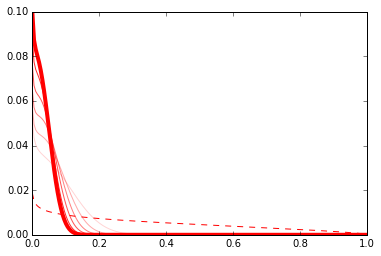

In [20]:
timesteps=376
states = np.linspace(0,1, num=200)
for i in range(1,timesteps, timesteps/6):
    plt.plot(states, Y_sol[i,:200], color='r', alpha=(i/float(timesteps)))
plt.plot(states, Y_sol[0,:200], 'r--')
plt.plot(states, Y_sol[-1,:200], 'r', linewidth=4)
plt.ylabel(r'$p(a_1)$', fontsize=15, **hfont)
plt.xlabel('Actions', fontsize=15, **hfont)
plt.savefig("a1_rd.eps", format='eps', dpi=1000)
plt.show()
#for line in Y_sol[:,:200]:
#    plt.plot(line)
#plt.show()
for i in range(1,timesteps, timesteps/6):
    plt.plot(Y_sol[i,200:], color='b', alpha=(i/float(timesteps)))
plt.plot(Y_sol[0,200:], 'b--')
plt.plot(Y_sol[-1,200:], 'b', linewidth=4)
plt.ylabel(r'$p(a_2)$', fontsize=15, **hfont)
plt.xlabel('Actions', fontsize=15, **hfont)
#plt.savefig("a2_rd.eps", format='eps', dpi=1000)
plt.show()

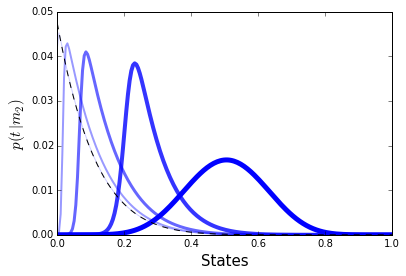

In [25]:
timesteps=376
for j, i in enumerate(range(1,timesteps, timesteps/5)):
    p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
    p_m2 =  X_sol[i,1::2] * prior.T
    p_t_m2 = p_ti_m2 / p_m2
    plt.plot(states, p_t_m2.tolist()[0], color='b', linewidth=5-j, alpha=(1 - (i/float(timesteps))))
# First state
#p_ti_m2 = np.multiply(X_sol[0,1::2], prior)
#p_m2 =  X_sol[0,1::2] * prior.T
#p_t_m2 = p_ti_m2 / p_m2
#plt.plot(states, p_t_m2.tolist()[0], 'b--')
# Last state
#p_ti_m2 = np.multiply(X_sol[-1,1::2], prior)
#p_m2 =  X_sol[-1,1::2] * prior.T
#p_t_m2 = p_ti_m2 / p_m2
#plt.plot(states, p_t_m2.tolist()[0], 'b', linewidth=4)
#
plt.plot(states, prior.tolist()[0], 'k--')
plt.ylabel(r'$p(t \mid m_2)$', fontsize=15) #, **hfont)
plt.xlabel('States', fontsize=15) #, **hfont)
plt.savefig("pt-m2-free-prior.pdf", format='pdf', dpi=1000)
#plt.savefig("pt-m2.pdf", format='pdf', dpi=1000)
plt.show()

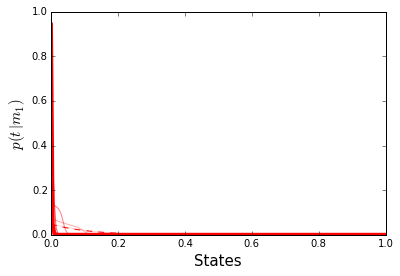

In [26]:
for i in range(1,timesteps, timesteps/6):
    p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
    p_m1 =  X_sol[i,0::2] * prior.T
    p_t_m1 = p_ti_m1 / p_m1
    plt.plot(states, p_t_m1.tolist()[0], color='r', alpha=(i/float(timesteps)))
# First state
p_ti_m1 = np.multiply(X_sol[0,0::2], prior)
p_m1 =  X_sol[0,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
plt.plot(states, p_t_m1.tolist()[0], 'r--')
# Last state
p_ti_m1 = np.multiply(X_sol[-1,0::2], prior)
p_m1 =  X_sol[-1,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
plt.plot(states, p_t_m1.tolist()[0], 'r', linewidth=4)
#
plt.ylabel(r'$p(t \mid m_1)$', fontsize=15, **hfont)
plt.xlabel('States', fontsize=15, **hfont)
plt.savefig("pt-m1-free-prior.pdf", format='pdf')
#plt.savefig("p_t_m1_rd.png", format='png')
plt.show()

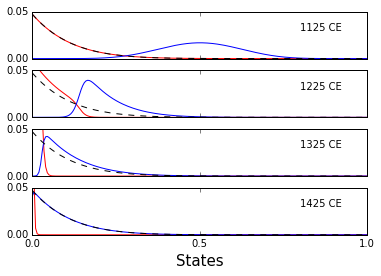

In [27]:
hfont = {'fontname':'Helvetica'}
# Push-chain
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
i=0
p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
p_m1 =  X_sol[i,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
ax1.plot(states, p_t_m1.tolist()[0], 'r')
p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
p_m2 =  X_sol[i,1::2] * prior.T
p_t_m2 = p_ti_m2 / p_m2
ax1.plot(states, p_t_m2.tolist()[0], 'b')
ax1.plot(states, prior.tolist()[0], 'k--')
ax1.text(.8, .03, str(1125+i)+' CE', **hfont)
#ax.annotate('Test', xy=(1, 0), xycoords='axes fraction', fontsize=16,
 #               horizontalalignment='right', verticalalignment='bottom')
#ax1.set_ylabel('common xlabel')
#ax1.ylim(0,.1)
#plt.show()
#
i=100
#plt.subplot(3,2,1)
p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
p_m1 =  X_sol[i,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
ax2.plot(states, p_t_m1.tolist()[0], 'r')
p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
p_m2 =  X_sol[i,1::2] * prior.T
p_t_m2 = p_ti_m2 / p_m2
ax2.plot(states, p_t_m2.tolist()[0], 'b')
ax2.plot(states, prior.tolist()[0], 'k--')
ax2.text(.8, .03, str(1125+i)+' CE', **hfont)
#ax2.ylim(0,.1)
#plt.show()
#
i=200
#plt.subplot(3,3,1)
p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
p_m1 =  X_sol[i,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
ax3.plot(states, p_t_m1.tolist()[0], 'r')
p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
p_m2 =  X_sol[i,1::2] * prior.T
p_t_m2 = p_ti_m2 / p_m2
ax3.plot(states, p_t_m2.tolist()[0], 'b')
ax3.plot(states, prior.tolist()[0], 'k--')
ax3.text(.8, .03, str(1125+i)+' CE', **hfont)
#
i=300
#plt.subplot(3,3,1)
p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
p_m1 =  X_sol[i,0::2] * prior.T
p_t_m1 = p_ti_m1 / p_m1
ax4.plot(states, p_t_m1.tolist()[0], 'r')
p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
p_m2 =  X_sol[i,1::2] * prior.T
p_t_m2 = p_ti_m2 / p_m2
ax4.plot(states, p_t_m2.tolist()[0], 'b')
ax4.plot(states, prior.tolist()[0], 'k--')
ax4.text(.8, .03, str(1125+i)+' CE', **hfont)
#
f.subplots_adjust(hspace=.25)
plt.locator_params(nbins=2)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
#
#plt.ylabel(r'$p(t \mid m)$', fontsize=15, **hfont)
plt.xlabel('States', fontsize=15, **hfont)
#
plt.ylim(0,.05)
plt.savefig("push-chain-free-prior.pdf", format='pdf', dpi=1000)
#plt.savefig("push_chain.eps", format='eps', dpi=1000)
plt.show()

# Estimating bias parameter from experimental data

In [7]:
from scipy.stats import beta

In [9]:
# Estimate bias paramter from experimental data
def b_estimate(params):
    return abs((1 - beta.cdf(.5, params[0], params[1])) - .28)
    
# return abs((1-.49) - beta.cdf(.5, params[0], params[1]))
#x0 = [1,2]
b_fit = minimize(b_estimate, [1, 1], method="SLSQP")
b_fit.x[0]/b_fit.x.sum()

0.33550153198332899

In [10]:
best = []
minimum = 100
for i in range(300):
    for j in range(300):
        diff = abs(1 - beta.cdf(.5, i, j) - .28)
        if diff < minimum:
            best = [i,j]
            minimum = diff

print best, minimum

[173, 184] 2.24458477548e-05


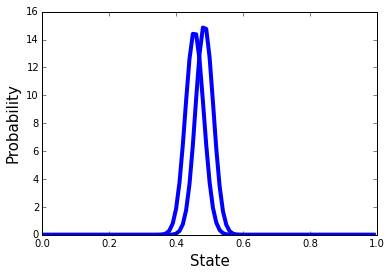

In [11]:
x = np.arange (0, 1, 0.01)
plt.plot(x, beta.pdf(x,152,182), linewidth=4, color='b')
plt.plot(x, beta.pdf(x,173,184), linewidth=4, color='b')
plt.ylabel("Probability", fontsize=15)
plt.xlabel("State", fontsize=15)
plt.show()

In [47]:
# Estimate bias parameter for 5% 
first_b_fit = minimize(lambda x: abs((1 - beta.cdf(.5, x[0], x[1])) - .05), [1, 1], method="Nelder-Mead")
print first_b_fit.x
print first_b_fit.x[0]/b_fit.x.sum()
# Estimate bias parameter for 28% 
second_b_fit = minimize(lambda x: abs((1 - beta.cdf(.5, x[0], x[1])) - .28), [1, 1], method="Nelder-Mead")
print second_b_fit.x
print second_b_fit.x[0]/b_fit.x.sum()

[ 0.18514521  1.76097251]
0.0921681293494
[ 0.6476339   1.29227196]
0.322402106552


In [ ]:
method_solutions = {}
for solver_method in ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "SLSQP"]:
    b_fit = minimize(lambda x: abs((1 - beta.cdf(.5, x[0], x[1])) - .50), [1, 1], method=solver_method)
    method_solutions[solver_method] = b_fit.x
x = np.arange (0, 1, 0.01)
for value in method_solutions.values():
    plt.plot(x, beta.pdf(x,value[0], value[1]), linewidth=4, color='b')
    plt.axvline(value[0]/value.sum())
plt.ylabel("Probability", fontsize=15)
plt.xlabel("State", fontsize=15)
plt.show()

In [44]:
method_solutions

{'BFGS': array([ 0.67374272,  1.33449906]),
 'CG': array([ 0.67058614,  1.32941386]),
 'COBYLA': array([ 1.13142087,  2.02883374]),
 'L-BFGS-B': array([ 0.77134789,  1.48924669]),
 'Nelder-Mead': array([ 0.6476339 ,  1.29227196]),
 'Powell': array([ 1.45719942,  2.48894452]),
 'SLSQP': array([ 0.67394772,  1.33482916]),
 'TNC': array([ 0.67058614,  1.32941386])}

In [32]:
method_solutions.values()

[array([ 0.67374272,  1.33449906]),
 array([ 0.77134789,  1.48924669]),
 array([ 0.6476339 ,  1.29227196]),
 array([ 0.67394772,  1.33482916]),
 array([ 0.67058614,  1.32941386]),
 array([ 1.13142087,  2.02883374]),
 array([ 0.67058614,  1.32941386]),
 array([ 1.45719942,  2.48894452])]

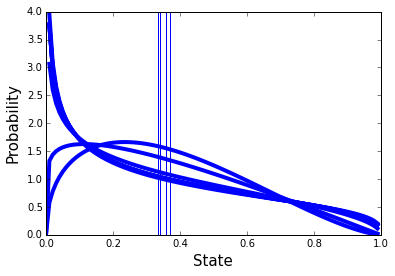

In [34]:
x = np.arange (0, 1, 0.01)
for value in method_solutions.values():
    plt.plot(x, beta.pdf(x,value[0], value[1]), linewidth=4, color='b')
    plt.axvline(value[0]/value.sum())
plt.ylabel("Probability", fontsize=15)
plt.xlabel("State", fontsize=15)
plt.show()

In [ ]:
for solver_method in ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "SLSQP"]:
    b_fit = minimize(lambda x: abs((1 - beta.cdf(.5, x[0], x[1])) - .05), [1, 1], method=solver_method)
    if b_fit['success']:
        print solver_method + ": ", b_fit.x, b_fit.x[0]/b_fit.x.sum()  

In [ ]:
np.rep